# cross-section as a function of $Q^2$
do we have a case for $m_A$?

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_results/'

In [3]:
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


# apply the efficiency weights - if they were not computed yet

## Draw the cross-sections

In [4]:
genie_mA_list   = ['0_70','0_99_nominal','1_3']
genie_mA_labels = [r'$m_A=0.7$',r'$m_A=0.99$',r'$m_A=1.3$']

In [18]:
afro_genie_CC1p_dict = dict()
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/'
for gname in genie_mA_list: 
    csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
    if os.path.isfile( csvfilename ) and False:#{
        afro_genie_CC1p_dict[gname] = pd.read_csv(csvfilename)
        print 'loaded',len(afro_genie_CC1p_dict[gname]),'afro GENIE CC1p '+gname+' events'
    #}
    else: #{
        afro_genie = pd.read_csv( path + 'CC_4_9E20_POT_mA_'+gname+'.csv')
        print 'loaded',gname
        afro_genie_contained = afro_genie[(afro_genie.IsCC_1p_200MeVc==True)
                            & ((afro_genie.v_x>3) & (afro_genie.v_x<256))                        
                            & ((afro_genie.v_y>-115) & (afro_genie.v_y<115))                        
                            & ((afro_genie.v_z>5) & (afro_genie.v_z<1037))                        
                           ]
        afro_genie_in_limits = sample_in_limits(sam=afro_genie_contained
                                       ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                       ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
        afro_genie_CC1p = afro_genie_in_limits[afro_genie_in_limits['IsCC_1p_200MeVc']==True]
        print len(afro_genie_CC1p),'afro GENIE CC1p'
        afro_genie_CC1p_in_cuts = afro_genie_CC1p[(np.abs(afro_genie_CC1p['theta_12']-90)<delta_theta_12)
                                                  &(afro_genie_CC1p['Pt']<Pt_max)
                                                  &(np.abs(afro_genie_CC1p['delta_phi']-180.)<delta_Delta_phi)]
        print len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p in kinematical cuts'
        csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
        afro_genie_CC1p_in_cuts.to_csv(csvfilename)
        print 'saved ',len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p '+gname+' events to',csvfilename    
        afro_genie_CC1p_dict[gname] = afro_genie_CC1p_in_cuts    
    #}
print 'done loading afro GENIE files'

loaded 0_70
21535 afro GENIE CC1p
16189 afro GENIE CC1p in kinematical cuts
saved  16189 afro GENIE CC1p 0_70 events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/afro_genie_CC1p_0_70.csv
loaded 0_99_nominal
33695 afro GENIE CC1p
25833 afro GENIE CC1p in kinematical cuts
saved  25833 afro GENIE CC1p 0_99_nominal events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/afro_genie_CC1p_0_99_nominal.csv
loaded 1_3
30886 afro GENIE CC1p
23131 afro GENIE CC1p in kinematical cuts
saved  23131 afro GENIE CC1p 1_3 events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/afro_genie_CC1p_1_3.csv
done loading afro GENIE files


In [19]:
for particle in ['mu','p']:
    genie_Xsec_dicts = dict()
    for iXsec,(remove_ctu_bin,Xsec_title,Xsec_name) in enumerate(zip(remove_ctu_bools,Xsec_ctu_titles,Xsec_fnames)):
        do_absolute_Xsec = True
        genie_Xsec_dicts[Xsec_title] = dict()
        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)        
            mul = 180./np.pi if 'phi' in observable else 1

            for gname,ls,glabel in zip(genie_mA_list,['-','--','-.',':'],genie_mA_labels):#{
                genie_model_CC1p = afro_genie_CC1p_dict[gname]  
                if remove_ctu_bin: #{
                    genie_model_CC1p = genie_model_CC1p[genie_model_CC1p['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                #}
                if do_absolute_Xsec:#{
                    genie_model_Xsec,genie_model_Xsec_err = compute_Xsec(Non=len(genie_model_CC1p), Non_err=np.sqrt(len(genie_model_CC1p)))                
                    genie_Xsec_dicts[Xsec_title][gname+' Xsec'] = genie_model_Xsec*4.908e19/4.9e20
                    genie_Xsec_dicts[Xsec_title][gname+' Xsec err'] = genie_model_Xsec_err*4.908e19/4.9e20
                    do_absolute_Xsec = False
                #}
                h_genie,_ = np.histogram(mul*genie_model_CC1p[vtrue],bins=bins)
                h_genie_err = np.sqrt(h_genie)
                genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
                for i_bin in range(len(bins)-1):#{
                    genie_Xsec[i_bin],genie_Xsec_err[i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20, 
                                                                           Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,                
                                                                           eff=1, bin_width=bin_width[i_bin] )
                #}
                genie_Xsec_dicts[Xsec_title][gname+' '+observable] = genie_Xsec
                genie_Xsec_dicts[Xsec_title][gname+' '+observable+' err'] = genie_Xsec_err
            #}
        #}
        print 'done',Xsec_title
    outfilename = Paths['1d Xsec'] + "P"+particle + "_genie_Xsecs_1D_different_MA.txt"
    with open(outfilename, 'w') as outfile:#{
        outfile.write(pickle.dumps(genie_Xsec_dicts))
    #}    
    print 'done',particle,'saved into \n',outfilename
print 'done.'

done excluding the last $\cos\theta_\mu$ bin
done with the last $\cos\theta_\mu$ bin
done mu saved into 
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/Pmu_genie_Xsecs_1D_different_MA.txt
done excluding the last $\cos\theta_\mu$ bin
done with the last $\cos\theta_\mu$ bin
done p saved into 
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/1d_Xsec/Pp_genie_Xsecs_1D_different_MA.txt
done.


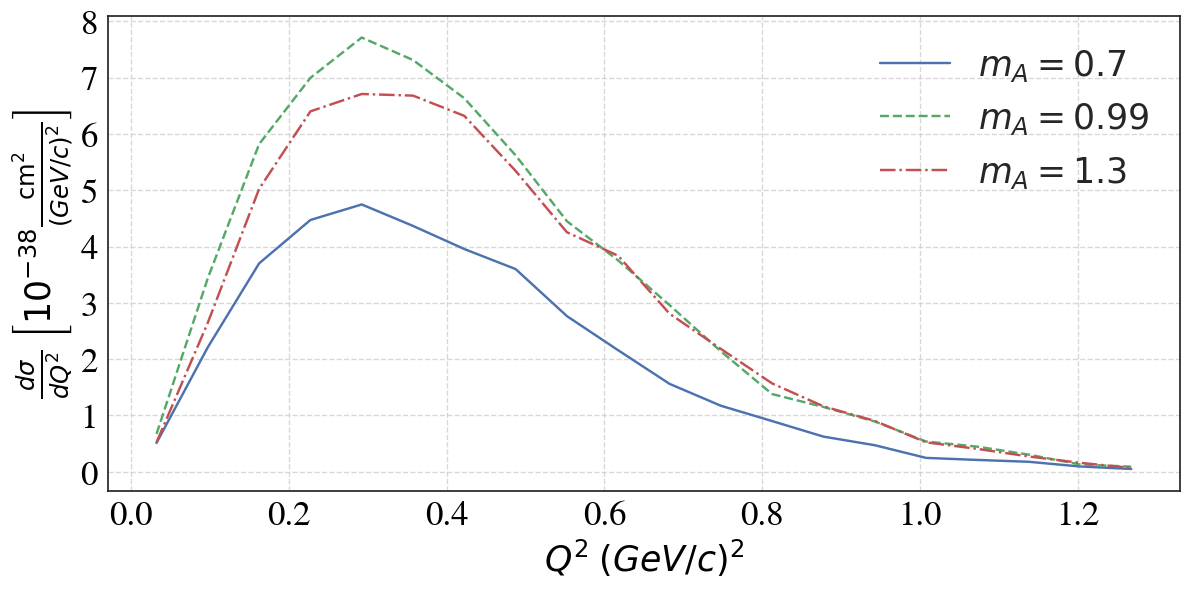

In [20]:
bins=linspace(0.,1.3,21)
vlabel=r'Q^{2}'; units='(GeV/c)^2'
wname = 'Pmu weight'
fig,ax = plt.subplots(figsize=(12,6))
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=bins[1:] - bins[:-1]
var='reco_Q2_mcs'
Xsec_ctu_title = Xsec_ctu_titles[0]
Xsec_dict = get_Xsec_variable(debug=debug,
                                                       var=var,bins=bins,
                                                       wname=wname,
                                                       remove_ctu_bin=True,
                                                       selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,
                                                       selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)    
tot_Xsec_genie = dict()
genie_Xsec = dict()
genie_Xsec_err=dict()
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    genie_mA = afro_genie_CC1p_dict[gname]
    genie_mA = genie_mA[genie_mA['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
    h_genie,_ = np.histogram(genie_mA['truth_Q2'],bins=bins)
    h_genie_err = np.sqrt(h_genie)
    genie_Xsec[gname],genie_Xsec_err[gname] = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin],genie_Xsec_err[gname][i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20,  
                                                                   Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,                                                                               
                                                                   bin_width=(bins[1]-bins[0]) )
    #}
    tot_Xsec_genie[gname] = np.sum(genie_Xsec[gname])
    
scale_genie = dict()    
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    scale_genie[gname] = tot_Xsec_genie['0_99_nominal']/tot_Xsec_genie[gname]
    scale_genie[gname] = 1
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin] = genie_Xsec[gname][i_bin]*scale_genie[gname]
        genie_Xsec_err[gname][i_bin] =  genie_Xsec_err[gname][i_bin]*scale_genie[gname]
    #}
#     mystep(x=mid ,x_width=bin_width, y=genie_Xsec[gname], y_width=genie_Xsec_err[gname], color='black',
#            linestyle=ls,
#            linewidth=3, ax=ax,label=glabel)
    plt.plot(mid,genie_Xsec[gname],label=glabel,linestyle=ls)
    
set_axes(ax,x_label='$'+vlabel+'$' + r' $%s$'%units
                 ,y_label=get_Xsec_label(vlabel,units)
                 ,do_add_grid=True,do_add_legend=True, legend_loc='best')        
plt.tight_layout()    

# cross-section as a function of $Q^2$

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_results/Q2_different_MA.pdf


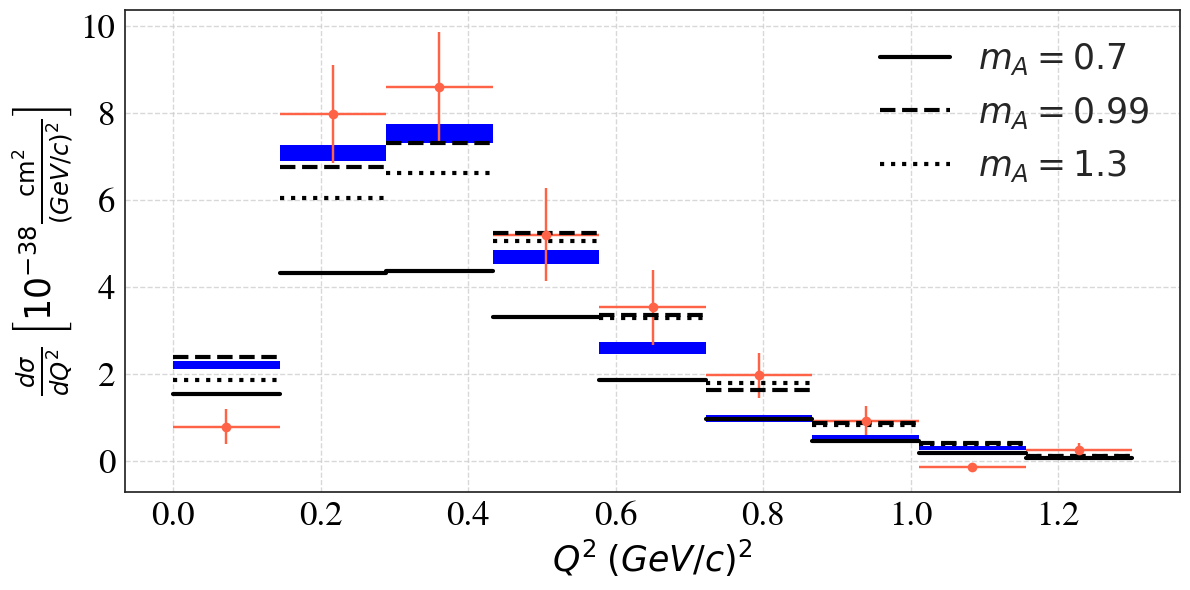

In [21]:
bins=linspace(0.,1.3,10)
vlabel=r'Q^{2}'; units='(GeV/c)^2'
wname = 'Pmu weight'
fig,ax = plt.subplots(figsize=(12,6))
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=bins[1:] - bins[:-1]
var='reco_Q2_mcs'
Xsec_ctu_title = Xsec_ctu_titles[0]
Xsec_dict = get_Xsec_variable(debug=debug,
                                                       var=var,bins=bins,
                                                       wname=wname,
                                                       remove_ctu_bin=True,
                                                       selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,
                                                       selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)    
h = dict()
h['Xsec'],h['Xsec err'] = Xsec_dict[var],Xsec_dict[var+' err']

ax.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],
            color=Colors['beam on'],fmt='o')        

h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+var], Xsec_dict['mc '+var+' err']
ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'],
       width=bin_width, color='blue')


tot_Xsec_genie = dict()
genie_Xsec = dict()
genie_Xsec_err=dict()
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    genie_mA = afro_genie_CC1p_dict[gname]
    genie_mA = genie_mA[genie_mA['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
    h_genie,_ = np.histogram(genie_mA['truth_Q2'],bins=bins)
    h_genie_err = np.sqrt(h_genie)
    genie_Xsec[gname],genie_Xsec_err[gname] = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin],genie_Xsec_err[gname][i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20,  
                                                                   Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,                                                                               
                                                                   bin_width=(bins[1]-bins[0]) )
    #}
    tot_Xsec_genie[gname] = np.sum(genie_Xsec[gname])
    
scale_genie = dict()    
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    scale_genie[gname] = tot_Xsec_genie['0_99_nominal']/tot_Xsec_genie[gname]
    scale_genie[gname] = 1

for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--',':']):
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin] = genie_Xsec[gname][i_bin]*scale_genie[gname]
        genie_Xsec_err[gname][i_bin] =  genie_Xsec_err[gname][i_bin]*scale_genie[gname]
    #}
    mystep(x=mid ,x_width=bin_width, y=genie_Xsec[gname], y_width=genie_Xsec_err[gname], color='black',
           linestyle=ls,
           linewidth=3, ax=ax,label=glabel)
    
set_axes(ax,x_label='$'+vlabel+'$' + r' $%s$'%units
                 ,y_label=get_Xsec_label(vlabel,units)
                 ,do_add_grid=True,do_add_legend=True, legend_loc='best')        
plt.tight_layout()    
outfilename = figures_path + 'Q2_different_MA.pdf'    
save_figure(outfilename)

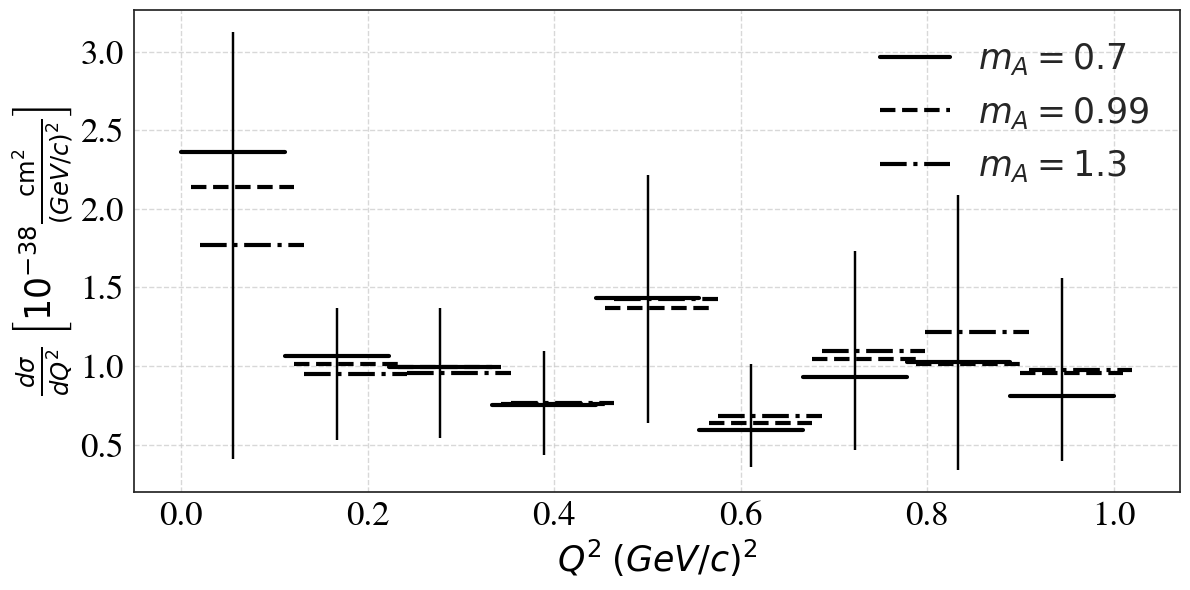

In [15]:
bins=linspace(0.,1.,10)
vlabel=r'Q^{2}'; units='(GeV/c)^2'
wname = 'Pmu weight'
fig,ax = plt.subplots(figsize=(12,6))
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=bins[1:] - bins[:-1]
var='reco_Q2_mcs'
Xsec_ctu_title = Xsec_ctu_titles[0]
Xsec_dict = get_Xsec_variable(debug=debug,
                                                       var=var,bins=bins,
                                                       wname=wname,
                                                       remove_ctu_bin=True,
                                                       selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,
                                                       selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)    
h = dict()
h['Xsec'],h['Xsec err'] = Xsec_dict[var],Xsec_dict[var+' err']

tot_Xsec_genie = dict()
genie_Xsec = dict()
genie_Xsec_err=dict()
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    genie_mA = afro_genie_CC1p_dict[gname]
    genie_mA = genie_mA[genie_mA['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
    h_genie,_ = np.histogram(genie_mA['truth_Q2'],bins=bins)
    h_genie_err = np.sqrt(h_genie)
    genie_Xsec[gname],genie_Xsec_err[gname] = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin],genie_Xsec_err[gname][i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20,  
                                                                   Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,                                                                               
                                                                   bin_width=(bins[1]-bins[0]) )
    #}
    tot_Xsec_genie[gname] = np.sum(genie_Xsec[gname])
    
scale_genie = dict()    
for gname,glabel,ls in zip(genie_mA_list,genie_mA_labels,['-','--','-.']):
    scale_genie[gname] = tot_Xsec_genie['0_99_nominal']/tot_Xsec_genie[gname]

ratio,ratio_err = dict(),dict()
for igenie,(gname,glabel,ls) in enumerate(zip(genie_mA_list,genie_mA_labels,['-','--','-.'])):
    ratio[gname],ratio_err[gname] = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
    for i_bin in range(len(bins)-1):#{
        genie_Xsec[gname][i_bin] = genie_Xsec[gname][i_bin]*scale_genie[gname]
        genie_Xsec_err[gname][i_bin] =  genie_Xsec_err[gname][i_bin]*scale_genie[gname]
        
        num = genie_Xsec[gname][i_bin]
        num_err = genie_Xsec_err[gname][i_bin]
        den = h['Xsec'][i_bin]
        den_err = h['Xsec err'][i_bin]
        ratio[gname][i_bin] =  num/den
        ratio_err[gname][i_bin] =  ratio[gname][i_bin]*np.sqrt(num_err/num + den_err/den)
    #}
    mystep(x=mid + 0.01*igenie*np.ones(len(mid)) ,x_width=bin_width, y=ratio[gname], y_width=ratio_err[gname], color='black',
           linestyle=ls,
           linewidth=3, ax=ax,label=glabel)
    
plt.errorbar(x=mid ,xerr=0, y=ratio[gname], yerr=ratio_err[gname], fmt='o', markersize=0, color='black')

set_axes(ax,x_label='$'+vlabel+'$' + r' $%s$'%units
                 ,y_label=get_Xsec_label(vlabel,units)
                 ,do_add_grid=True,do_add_legend=True, legend_loc='best')        
plt.tight_layout()

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_results/reco_Q2_mcs_Xsec.pdf


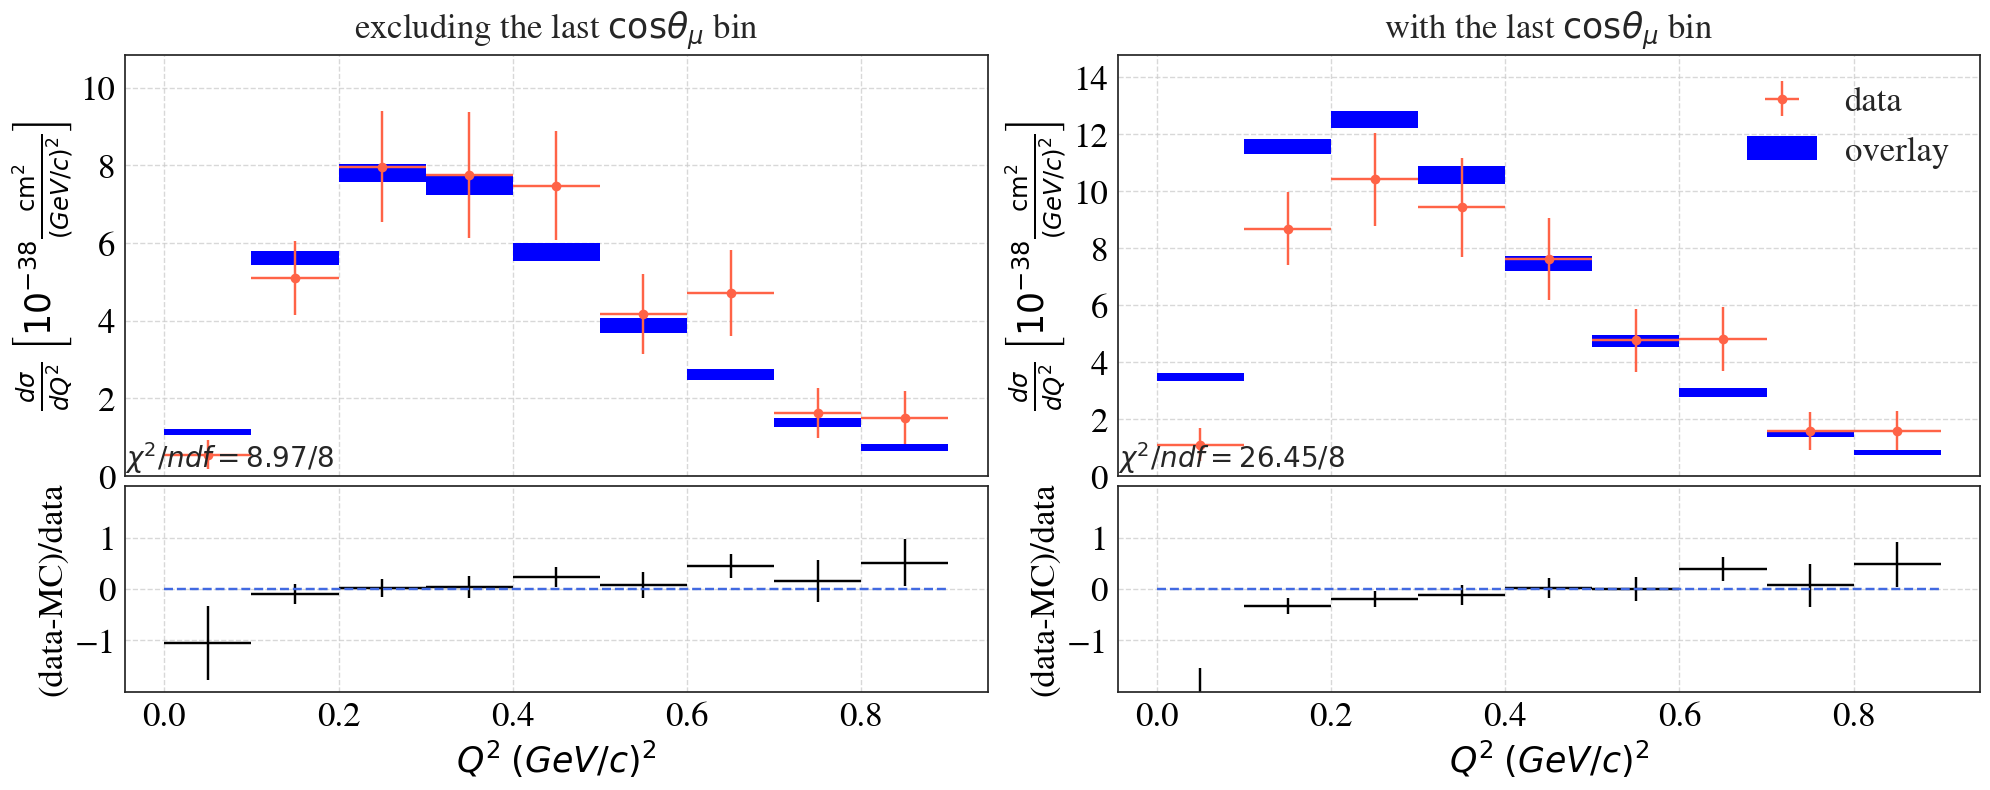

In [10]:
draw_Xsec_variable(var='reco_Q2_mcs',bins=linspace(0,0.9,10),vlabel=r'Q^2',units='(GeV/c)^2',figures_path=figures_path,
                      wname='Pmu weight',
                      selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,        
                      selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p,debug=0,
                   residuals_ylim=[-2,2],residuals_yticks=[-1,0,1],residuals_xtitle='left');